# Text Classfication and KNN

In this experiment we will examine how to turn the following values in our columns, example: ***"Director of Data Science, Machine Learning at Walmart Global Tech"*** into a specific **category**. The purpose of this experiment is to get a better understanding on what type of profiles Headline correlate to the industry their in. We later use the bag of words model, where each Headline represents a persons profile and their current position. TF-IDF is used to to calculate the Headlines from each profile.

In [1]:
# importing our libraries
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt

### Encode Headline as an Integer

In this section we import our data set and encode the headline column as an integer to better represent by integers instead of string values.

In [2]:
# import our data set
data = pd.read_csv('../excel-data/2_update-linkedin.csv')

# Create a new category id
data['category_id'] = data['Headline'].factorize()[0]
category_id_df = data[['Headline', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Headline']].values)
data.head()

,Headline,Industry,category_id
0,"Director of Data Science, Machine Learning at ...",Machine Learning,0
1,Leverage System-On-Chip Software and Deep Lear...,Machine Learning,1
2,Machine Learning Research Scientist - Deep Lea...,Machine Learning,2
3,Principal Data Scientist at Accenture,Machine Learning,3
4,Vice President of Machine Learning at Walmart ...,Machine Learning,4


### Our data set (showcased using matplotlib)
This graph shows the professionals by frequency.

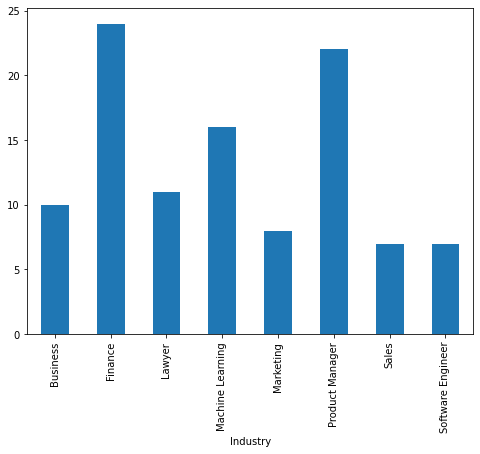

In [3]:
fig = plt.figure(figsize=(8,6))
data.groupby('Industry').Headline.count().plot.bar(ylim=0)
plt.show()

## Text Representation

During this phase we'll turn our imbalance "Headline" column and classify its values into the bag of words. 

sublinear_df - is set to true to use a O(logn) form for our frequency
min_df - the min number of Headline
stop_words - Remove all common pronouns such as "a" and "the"

In [4]:
# vectorizing our data sets
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(data.Headline).toarray()
labels = data.category_id
features.shape

(105, 28)

In [5]:
from sklearn.feature_selection import chi2
import numpy as np

N = 2
for Value, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names_out())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(Value))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))
    print("---------------------------------------------------------------------\n")

# 'Adjunct Professor, NYU Tandon and NYU Courant':
  . Most correlated unigrams:
. director
. product
  . Most correlated bigrams:
. machine learning
. product manager
---------------------------------------------------------------------

# 'American lawyer and diplomat, Senior Fellow at American Enterprise Institute':
  . Most correlated unigrams:
. senior
. lawyer
  . Most correlated bigrams:
. machine learning
. product manager
---------------------------------------------------------------------

# 'Antitrust Lawyer and Previous Chair, Antitrust Section of American Bar Ass'n':
  . Most correlated unigrams:
. product
. lawyer
  . Most correlated bigrams:
. machine learning
. product manager
---------------------------------------------------------------------

# 'Assistant Director of Sales and Leasing / Playwright / Photographer':
  . Most correlated unigrams:
. director
. sales
  . Most correlated bigrams:
. machine learning
. product manager
--------------------------------------

### Naive bayes classifier
We then use a Naive bayes classifier to predict the Headline to its corresponding industry. 

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(data['Headline'], data['Industry'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)


### Predicting our data sets

We use the prediction method from above and create a new Column called Headline_vec which contains the following prediction from each Headline.

In [8]:
def predict_headline(item):
    return clf.predict(count_vect.transform([item]))[0]

new_data = data

items = ["" for x in range(len(new_data['Headline']))]

for i, item in enumerate(new_data['Headline']):
    new_data['Headline_v'][i] = predict_headline(item)

new_data

KeyError: 'Headline_v'

## One hot encoding our data set

In this section we perform similar steps as but instead of using the Industry column we use the Headline_vec which we've usesd to predict the Headlines words from up above. The result for the following prediction is 72% which is really low compared to our previous prediction without using text-transformation. We aim later on in our research to improve the precision of our algorithm to make sure it detects the makes an accurate prediction for the Headline column. 

In [ ]:
# new imports
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [ ]:
# Prepocessing the data set (One hot coder with sklearn)
label = preprocessing.LabelEncoder()
enc = preprocessing.OneHotEncoder()

In [ ]:
x = new_data.apply(label.fit_transform)
enc.fit(x)
onehotlabels = enc.transform(x).toarray()
onehotlabels.shape

In [ ]:
x.keys()

In [ ]:
df = pd.DataFrame(x)
df.head()

## Standardize the data set

- It is difficult to visualize our high dimensional data
- We'll use PCA to find the first two principle components, and visualize the data in a new two-dimensonal space.
- Before using PCA we'll need to scale our data so that our feature has a single unit of variance.

In [ ]:
scaler = StandardScaler()
scaler.fit(df)
scaled_data = scaler.transform(df)

In [ ]:
# increase pca and compare & contrast
pca = PCA(n_components=2)

In [ ]:
pca.fit(scaled_data)

In [ ]:
x_pca = pca.fit_transform(scaled_data)
scaled_data.shape
x_pca.shape

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0],x_pca[:,1], c=x['Headline_vec'], cmap='plasma')

plt.xlabel('First principle component')
plt.ylabel('Second principle component')

### Labeling and plotting our PCA components

Previously we had many other columns that had little to no corrolation with each other. Due to the inconclusivity we've reduced the amount of columns and only used the **Headline** and **Industry**. The plot above tells us that our data set appears to be strongly related, which indicates that the following plots in our data sets are nearby from each other.

In [ ]:
principleDf = pd.DataFrame(data=x_pca, columns=['PC-1','PC-2'])
finalDf = pd.concat([principleDf, df['Industry']], axis=1)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)

# Labeling the dimensions
targets = ["Machine Learning", "Finance", "Product Manager", "Business", "Software Engineer", "Marketing", "Lawyer"]
colors = ["#de6564", "#56f5b3", "#de6fda", "#385000", "#91682c", "#8855dd", "#dea34e"]

for i, target in (enumerate(targets)):
    indKeep = finalDf['Industry'] == i
    ax.scatter(finalDf.loc[indKeep, 'PC-1'], finalDf.loc[indKeep, 'PC-2'], c=colors[i], s=50)

# phrase 2vector
ax.legend(targets)
ax.grid()
plt.show()

In [ ]:

# Labeling the dimensions
targets = ["Machine Learning", "Finance", "Product Manager", "Business", "Software Engineer", "Marketing", "Lawyer"]
colors = ["#de6564", "#56f5b3", "#de6fda", "#385000", "#91682c", "#8855dd", "#dea34e"]

for i, target in (enumerate(targets)):
    indKeep = finalDf['Industry'] == i
    ax.scatter(finalDf.loc[indKeep, 'PC-1'], finalDf.loc[indKeep, 'PC-2'], c=colors[i], s=50)

# phrase 2vector
ax.legend(targets)
ax.grid()
plt.show()

### Performing KNN on our word2vec column
After performing our word2vec for our headline column we see some similarities from our column industry data set. In this section we'll apply KNN to accurately predict ones relations with another profile based on their Headline.

### Splitting the data set

In [ ]:
X = x_pca
y = x['Headline_vec']

print("X-SHAPE", X.shape)
print("Y-SHAPE", y.shape)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

### Applying KNN to our updated data set

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

In [ ]:
pred = knn.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score

In [ ]:
print(confusion_matrix(y_test,pred))

In [ ]:
print(accuracy_score(y_test, pred))

In [ ]:
print(classification_report(y_test,pred))